## 今回の目標:

オイラー法やルンゲ・クッタ法を用いて、与えられた微分方程式を満たす関数を数値計算でプロットしてみる。

## 動機:

微分方程式はあらゆる科学分野や、経済学にまで現れる。それらの微分方程式を数値的に解いてグラフ化できれば、
解析的に解けるものについては自分の解の検算になり、解析的に解けないものについてはグラフの振る舞いを知ることができる。

## 減衰振動

まず、身近な微分方程式の例として、おもりがばねの復元力と空気抵抗を受けて運動する場合を考えよう。

このような運動は減衰振動と呼ばれ、
おもりの座標xについての微分方程式は

#### $$ m\frac{\mathrm{d}^2x}{\mathrm{d}t^2} = -kx - cv $$

で表される。これを、

#### $$ \frac{dx}{dt} = v $$

#### $$ m\frac{dv}{dt} = -kx -cv $$

という二つの一階微分方程式に分けることで数値計算が行えるようになる。

まずはオイラー法で数値計算を行おう。

オイラー法やルンゲクッタ法について知らないという場合は、このNotebookの一番下にある「参考資料」の、「科学技術計算講座1,2」を参考にしてほしい。


In [55]:
#Julia
#描画に必要なライブラリをインポートする
using Pkg
using Plots
Pkg.add("Plots")
Pkg.add("GR")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


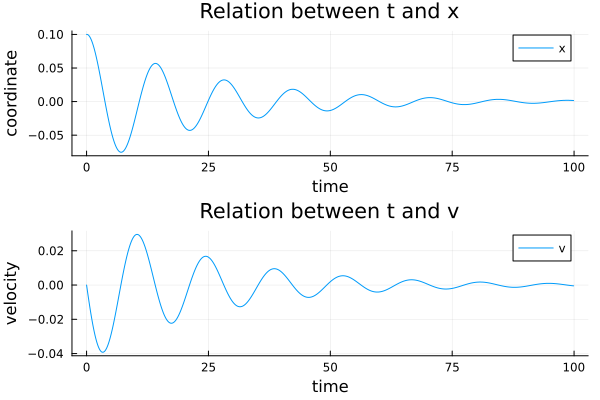

In [51]:
#初期条件
x = 0.1
v = 0.0
t = 0.0

k = 0.2 #ばね定数
c = 0.1 #抵抗 -cv の係数 (ばね‐質量‐ダンパー系というものや、空気抵抗を想定する)
m = 1.0 #質量
dt = 0.1

gt = []
gx = []
gv = []

# 簡略化のために関数を設定する
# dx/dt,dv/dt をそれぞれ fx,fv とおく

fx(v) = v
fv(x,v,k,c,m) = (-k * x - c * v) / m

#オイラー法を実行する
#a,bをfx,fvなどと命名すると invalid redefinition of constant Main.fx というバグが出ることがある。注意！
for i in 1:1000

    push!(gt,t)
    push!(gx,x)
    push!(gv,v)

    a = fx(v)
    b = fv(x,v,k,c,m)
    x = x + dt * a
    v = v + dt * b
    t = t + dt


end

#plotの使い方は https://zenn.dev/ohno/articles/3101433fbe9231 を参照
px = plot(gt,gx,title="Relation between t and x", label="x", xlabel="time", ylabel="coordinate")
pv = plot(gt,gv,title="Relation between t and v", label="v",xlabel="time", ylabel="velocity")
plot(px, pv,layout = (2, 1))

おもりは振動しつつ、最終的にはつりあいの位置で停止することが予想されるので、それらしいグラフを得ることができた。

ここで、このグラフがどれくらい正確なものなのかを考えたい。

減衰振動の微分方程式は解析的に解けて、
## $ x = a e^{-\gamma t} \cos({\sqrt{\omega^2-\gamma^2} t+\alpha}) $

ここで
$ a = \sqrt{\omega^2 x_0^2/\omega^2-\gamma^2}、\alpha = \tan^{-1}(-\gamma/\sqrt{\omega^2-\gamma^2})、\gamma = c/(2m)、\omega = \sqrt{k/m} $

という厳密解が存在することが知られている。今　$x_0 = 0.1 $ として、実際にこの厳密解 $ x(t) $ のグラフと、オイラー法で得られたグラフを比較してみよう。

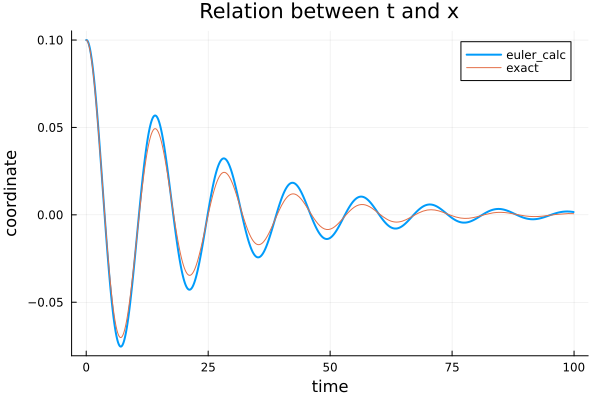

In [52]:
#厳密解が存在するので、数値計算の結果とそれを比べてみる

x0 = 0.1
gamma = c/(2m)
omega = sqrt(k/m)
alph = atan(-gamma/sqrt(omega^2-gamma^2))
a = sqrt((omega*x0)^2/(omega^2-gamma^2))
exact(t) = a * cos(sqrt(omega^2-gamma^2)*t + alph) * exp(-gamma * t)

#pxのラベルを"euler_calc"とする
pxEuler = plot(gt,gx,title="Relation between t and x", label="euler_calc", xlabel="time", ylabel="coordinate",lw=2)
plot!(pxEuler,exact,label="exact")

オイラー法は確かに微分方程式を満たす関数をうまく近似できるものの、まだ計算精度が甘いことがわかった。

次に、より計算精度が良いと言われるルンゲ・クッタ法で $x(t)$ のグラフを書いてみよう。

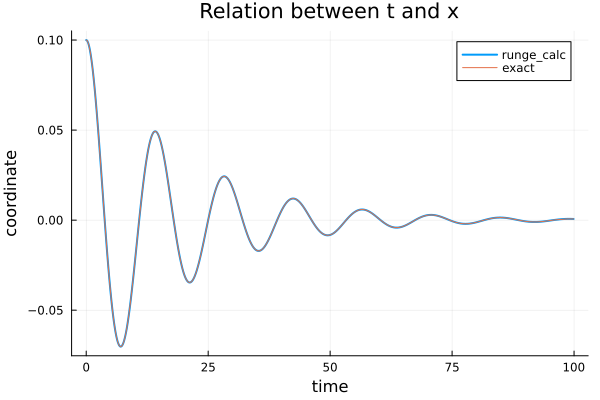

In [53]:
#初期条件
x = 0.1
v = 0.0
t = 0.0
gt = []
gx = []
gv = []

#ワンステップずつ計算していく
for i in 1:1000

    push!(gt,t)
    push!(gx,x)
    push!(gv,v)
    
    xp = x
    vp = v
    kx1 = fx(vp)
    kv1 = fv(xp, vp, k, c, m)

    xp = x + 0.5 * dt * kx1
    vp = v + 0.5 * dt * kv1
    kx2 = fx(vp)
    kv2 = fv(xp, vp, k, c, m)

    xp = x + 0.5 * dt * kx2
    vp = v + 0.5 * dt * kv2
    kx3 = fx(vp)
    kv3 = fv(xp, vp, k, c, m)

    xp = x + dt * kx3
    vp = v + dt * kv3
    kx4 = fx(vp)
    kv4 = fv(xp, vp, k, c, m)

    x = x + dt * (kx1 + 2.0 * kx2 + 2.0 * kx3 + kx4) / 6.0
    v = v + dt * (kv1 + 2.0 * kv2 + 2.0 * kv3 + kv4) / 6.0
    t = t + dt

end

pxRunge = plot(gt,gx,title="Relation between t and x", label="runge_calc", xlabel="time", ylabel="coordinate",lw=2)
plot!(pxRunge,exact,label="exact")

ルンゲクッタ法は確かに計算精度が良いことが見てとれた。
他の微分方程式も、ルンゲクッタ法を用いて数値的に解いてみよう。

## ロトカ・ヴォルテラ方程式

生物の捕食-被食関係による個体数の変動を表現するシンプルな数理モデルとして、ロトカ・ヴォルテラの方程式というものがある。
これは
### $$ \frac{\mathrm{d}x}{\mathrm{d}t} = ax - bxy $$
### $$ \frac{\mathrm{d}y}{\mathrm{d}t} = cxy - dy $$

という連立微分方程式である。

ここで、$x$は非捕食者(弱い方)の数、$y$は捕食者(強い方)の数であり、
定数$a,b,c,d$については、それぞれ大まかに$a$は被捕食者の出生率、$b$は被捕食率、$c$は捕食者の出生率、$d$は捕食側の死亡率を表す。

### 式の説明
この式の意味は意外と単純なので、怖気付かないでほしい。
まず上の式について説明する。$-bxy$の項がなかったら$x(t)=e^{at}$となる。すなわち、被捕食者の数は指数関数的に増え続ける(と仮定している)。
また、捕食者と被食者が出会う場合を考えると、この機会は$x$の数と$y$の数に比例すると考えられるので、$-bxy$で被食者の減少を表せる。

次に、下の式について説明する。まず、ここで捕食者$y$は$x$以外に餌を持たないとしている。
$cxy$の項が非常に小さいとき、捕食者は少ない餌を奪い合って、自らの個体数が多いほどに急激に減少していく。この減少は指数関数的なものなので、$-dy$と表せる。
$cxy$の項については、$-bxy$の逆作用と考えればよい。ここでは餌を食べることに成功すればするほど個体数を増やせるとしている。

このように、$x$や$y$の二次以上の項が入った微分方程式を非線形微分方程式と言い、一般に解析的に解くことはできない。この式も解析的に解くことはできないが、数値計算によって$x$や$y$の振る舞いを知ることができる。実際にルンゲクッタ法で、この微分方程式を数値的に解いてみよう。

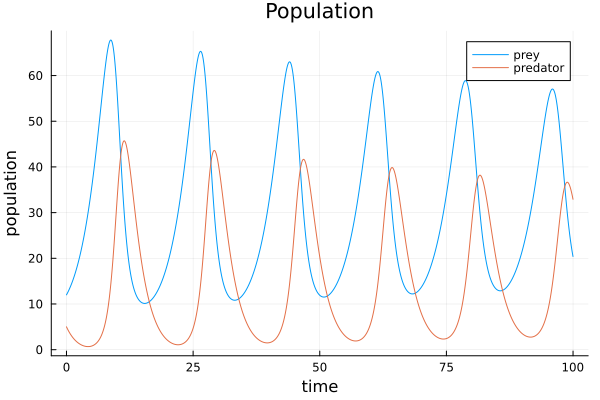

In [161]:
#パラメータ、初期値をうまく定めてやる
a,b,c,d = 0.3, 0.1, 0.1, 3

x = 12
y = 5
t = 0

gx = []
gy = []
gt = []
dt = 0.01

#微分方程式の右辺の計算を簡潔に表すため、関数を定義する
# =を使った記法により、変数を呼び出す必要がなくなる

fx(x=xp,y=yp) = a*x - b*x*y
fy(x=xp,y=yp) = c*x*y - d*y

for i in 1:10000

    push!(gt,t)
    push!(gx,x)
    push!(gy,y)
    
    xp = x
    yp = y
    kx1 = fx()
    ky1 = fy()

    xp = x + 0.5 * dt * kx1
    yp = v + 0.5 * dt * ky1
    kx2 = fx()
    ky2 = fy()

    xp = x + 0.5 * dt * kx2
    yp = v + 0.5 * dt * ky2
    kx3 = fx()
    ky3 = fy()

    xp = x + dt * kx3
    yp = v + dt * ky3
    kx4 = fx()
    ky4 = fy()

    x = x + dt * (kx1 + 2.0 * kx2 + 2.0 * kx3 + kx4) / 6.0
    y = y + dt * (ky1 + 2.0 * ky2 + 2.0 * ky3 + ky4) / 6.0
    t = t + dt

end


px = plot(gt,gx,label="prey")
plot!(px,gt,gy,title="Population", label="predator", xlabel="time", ylabel="population")

- 獲物の数が増える
- それに遅れて捕食者の数が増え始め、獲物は減る
- 捕食者は食べるものがなくなって数を減らし、再び獲物が増え始める

というサイクルが起こることが、解析的に微分方程式を解かずとも知ることができた。

## まとめ
今回はJuliaでオイラー法とルンゲクッタ法を実装し、微分方程式を数値的に解くことができた。

## 展望

今回は触れなかったが、二階線形微分方程式なども $dx/dt = u$ のように変数変換することで数値計算することができる。これを活かして今後もさまざまな微分方程式を計算してみたい。
一方、ルンゲクッタ法は精度がいいものの完璧ではなく、新たな数値計算法も考えられていることには留意する必要がある。
また、拡散方程式などの偏微分方程式の数値計算はルンゲクッタ法では行えないため、それらを行う方法についても今後学びたい。

調べている途中で知った、今後につながりそうなワードを列挙しておく。

- 具体的な微分方程式
    - HJB方程式　(最適制御理論の根幹をなす偏微分方程式)
    - Lorenz方程式　(カオス的な解を持つ、大気変動に関する非線形常微分方程式)
    - ベルヌーイ型・リッカチ型微分方程式
    - ベッセル関数
    - ロジスティック方程式
    - フォン・ベルタランフィの成長曲線

- 数学的・数理科学的用語
    - 可積分系・非可積分系
    - アイソクライン法
    - (微分方程式の)解曲線
    - (微分方程式の)保存量、保存系
    - 構造安定
    - 幻影解

- 生態学的用語
    - マルサスモデル
    - アリー効果
    - 環境収容力

- Jupyter Notebook の記法
    - Markdown記法
    - $\rm\LaTeX$

## 参考資料(特に役に立ったサイト):
- 科学技術計算講座1,2 https://cattech-lab.com/science-tools/simulation-lecture/#lec2
- 【python】ロトカ-ヴォルテラ方程式とかいう超絶かっこいい数式でライオンとガゼルの争いを再現してみた https://qiita.com/kj455/items/32fef8f04d461d36a92a
- Plots.jl入門 https://zenn.dev/ohno/articles/3101433fbe9231

